このプログラムでは、実験結果から事後分布をそれぞれ求め`改良前後の実験データの比較`を行う。

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

from mpl_toolkits.axisartist.axislines import SubplotZero

setUniformDistribution関数では、試行結果を反映させる前の事前分布$p(t)$を作成する。

In [2]:
def setUniformDistribution(step):
    return np.full(step + 1, 1/step)

getLikelihood関数では、尤度分布$p(a|t)$を作成します。

In [3]:
def getLikelihood(result, step):
    if result == "完走":
        return [1/step * i for i in range(step+1)]
    elif result == "失敗":
        return [1-(1/step * i) for i in range(step+1)]
        

getPosteriorDistribution関数では、尤度分布と事前分布を掛け合わせ事後分布を作成する。

In [4]:
def getPosteriorDistribution(likelihood, prior_dist):
    return likelihood * prior_dist

normalize関数では、事後分布の積分が1になるような正規化定数（周辺尤度）$η$を求める。

In [5]:
def normalize(poster_dist):
    norm_const = 1/sum(poster_dist)
    return norm_const * poster_dist

In [6]:
def getStdev(mean, poster_dist, prob):
    return math.sqrt(sum([po*pow(pr, 2)
                         for (po, pr) in zip(poster_dist, prob)]) - pow(mean, 2))

In [7]:
def splitData(results_list):
    result = []
    results = []
    for r in results_list:
        if r == "," or r == "\n":
            results.append(result[:])
            result.clear()
            continue
        result.append(r)
    results.append(result)
    return results

In [8]:
def checkData(results_list):
  for results in results_list:
      for result in results:
        if not(result=="完走" or result=="失敗"):
          raise ValueError("引数として、'完走'か'失敗'、区切りのための','のみしか受け付けていません")

In [9]:
def plot(poster_dists, prob, step, scale):
    fig = plt.figure(figsize = (12,6))
    ax = SubplotZero(fig, 111)
    fig.add_subplot(ax)

    for poster_dist , idx in zip(poster_dists, range(len(poster_dists))):
        prob_mean = sum([po*pr for (po, pr) in zip(poster_dist, prob)])
        prob_stdev = getStdev(prob_mean, poster_dist, prob)
        print(prob_mean, prob_stdev)
        prob_stdev_min = prob_mean - prob_stdev
        prob_stdev_max = prob_mean + prob_stdev
        if prob_stdev_min < 0:
            prob_stdev_min = 0
        if prob_stdev_max > 1:
            prob_stdev_max = 1

        text_height = np.max(poster_dist)
        
        ax.bar(prob, poster_dist, width=1/step, edgecolor="black", alpha=0.6)
        ax.text(prob_mean - 0.025,
                text_height*scale+0.1, "平均", size=20)
        ax.plot([[prob_mean]for i in range(2)],
                [0, text_height*scale+0.1], lw=2, color="r")
        ax.fill_between([prob_stdev_min, prob_stdev_max],
                        [0, 0],
                        [text_height + 0.09, text_height + 0.09], alpha=0.2, color='red')
        ax.text(prob_mean-0.06, text_height*scale+0.05, "標準偏差", size=20)
        ax.annotate('',
                    xy=[prob_stdev_min, text_height*scale+0.05],
                    xytext=[prob_stdev_max, text_height*scale+0.05],
                    arrowprops=dict(arrowstyle='<|-|>',
                                    connectionstyle='arc3',
                                    facecolor='C0',
                                    edgecolor='C0'))
        if(idx == 0):
          ax.text(prob_mean-0.05, text_height*scale +0.2, "改良前", size=25)
        else:
          ax.text(prob_mean-0.05, text_height*scale +0.2, "改良後", size=25)
        fig.add_subplot(ax)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 0.8)
    for direction in ["right", "top"]:
        ax.axis[direction].set_visible(False)
    for direction in ["left",  "bottom"]:
        ax.axis[direction].set_axisline_style("-|>")
    ax.grid(which='major', color='black')
    ax.grid(which='minor', color='gray', linestyle='--')
    ax.tick_params(labelsize=30)
    ax.set_xlabel("完走率", fontname='IPAGothic', fontsize=50)
    ax.set_ylabel("確率", fontname='IPAGothic', fontsize=50)
    plt.show()

In [10]:
step = 100
results_data =["完走", "失敗", "失敗", "完走", "完走", ",",  "完走", "完走", "完走", "完走", "完走"] #改良前、改良後
prob = [1/step * i for i in range(step+1)]

prior_dist = np.array([])
poster_dist = np.array([])
poster_dist_list = []
likelihood = np.array([])

results_list = splitData(results_data)
try:
  checkData(results_list)
except ValueError as e:
    print(e)
    exit(1)

このforループでは、それぞれ試行結果から事後分布（$p(t|a_{1:i+1})$）を求める。

$$ p(t|a_{1:i+1}) = ηp(a_{i+1}|t)p(t|a_{1:i}) $$


In [11]:
for results in results_list:
    prior_dist = setUniformDistribution(step)
    for result in results:
        likelihood = getLikelihood(result, step)
        poster_dist = getPosteriorDistribution(likelihood, prior_dist)
        poster_dist = normalize(poster_dist)
        prior_dist = poster_dist
    poster_dist_list.append(poster_dist.tolist())

0.5714285571442856 0.1749635384771017
0.8613859271535351 0.12430521452606962


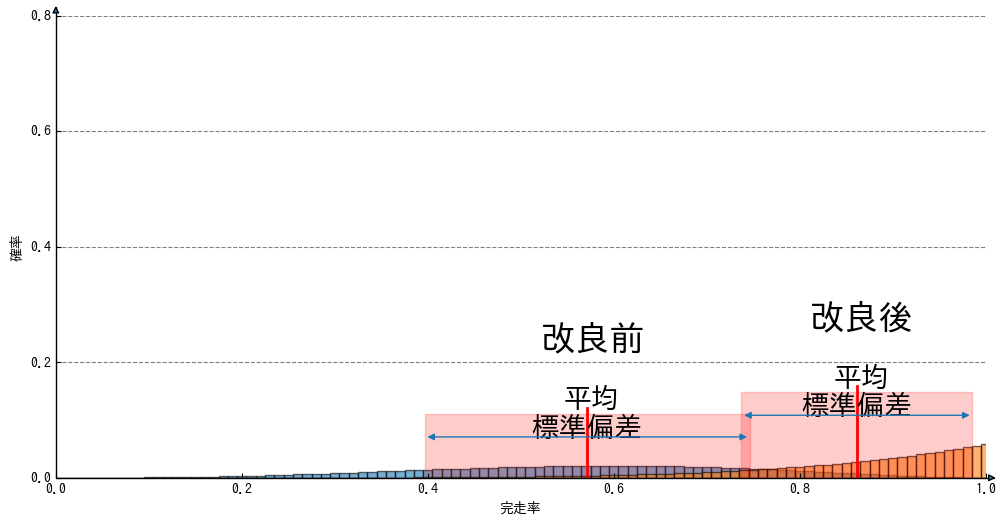

In [12]:
plot(poster_dist_list, prob, step, 1.0)

改良前と改良後の事後分布をプロットした図を見ると、  
改良前の平均が0.57、標準偏差が0.17  
改良後の平均が0.86、標準偏差が0.12
であることがわかる。  

改良後の分布の方が完走率の平均が大きく、完走率のばらつき具合を示した標準偏差が小さいことがわかる。  
しかし、分布が重なっている部分があるため、  
完走率が改良前後で変わらない場合やむしろ悪化する場合があるため試行を増やす必要があることがわかる

そのため、現在の試行結果の10倍増やした結果を試行結果とし、事後分布を求め直す。

In [13]:
import itertools

def augmenData(results_data, augment_rate):
    [results_data.insert(results_data.index(','), result) for result in results_data[0:results_data.index(',')]*(augment_rate-1)]
    [results_data.insert(results_data.index(',')+1, result) for result in results_data[results_data.index(',')+1:len(results_data)]*(augment_rate-1)]
    return results_data

0.5961538461538457 0.06739834243942626
0.9852598230946976 0.018740634147556414


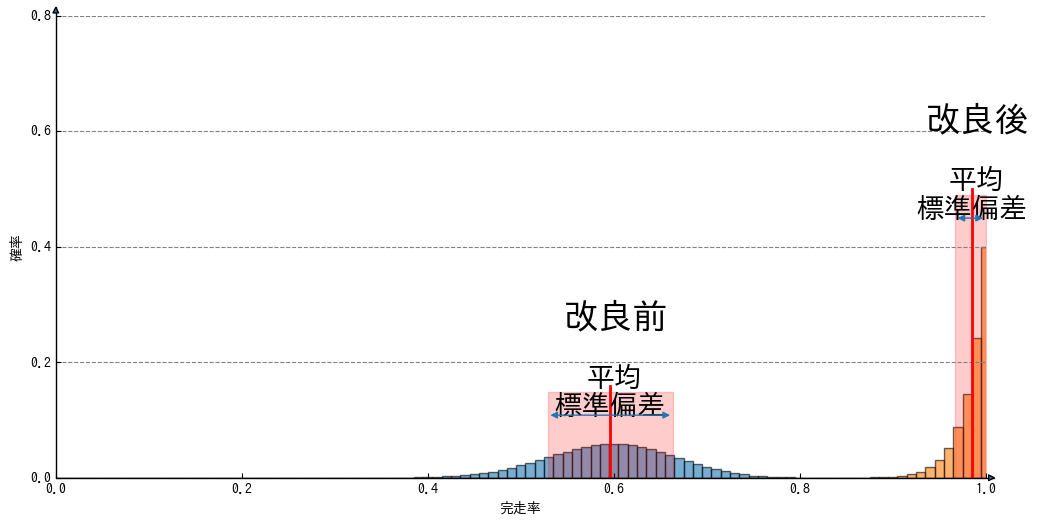

In [14]:
step = 100
data_augment_rate = 10
results_data =["完走", "失敗", "失敗", "完走", "完走", ",",  "完走", "完走", "完走", "完走", "完走"] #改良前、改良後
prob = [1/step * i for i in range(step+1)]

prior_dist = np.array([])
poster_dist = np.array([])
poster_dist_list = []
likelihood = np.array([])

results_data = augmenData(results_data, data_augment_rate)
results_list = splitData(results_data)
try:
  checkData(results_list)
except ValueError as e:
    print(e)
    exit(1)

for results in results_list:
    prior_dist = setUniformDistribution(step)
    for result in results:
        likelihood = getLikelihood(result, step)
        poster_dist = getPosteriorDistribution(likelihood, prior_dist)
        poster_dist = normalize(poster_dist)
        prior_dist = poster_dist
    poster_dist_list.append(poster_dist.tolist())
    

plot(poster_dist_list, prob, step, 1.0)

試行を10倍に増やしたところ、それぞれの事後分布が重なる部分が無くなった。  
そのため、改良前と改良後で何かしらの効果があり改善されたといえるようになった、と考える。

このことから、結果を比較するために必要な事後分布を作成には、多くの試行結果が必要であることがわかった。